In [1]:
#import pakietów
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
# stworzenie obiektu dataframe z otagowanymi nazwami plików
filenames = os.listdir("train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


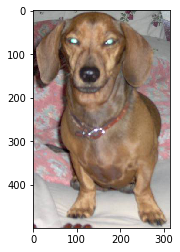

In [4]:
# przykLadowy obraz ze zbioru
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image);

In [5]:
# budowa modelu 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [6]:
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
#earlystop = EarlyStopping(patience=10)

In [8]:
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
 #                                           patience=2, 
  #                                          verbose=1, 
   #                                         factor=0.5, 
    #                                        min_lr=0.00001)

IndentationError: unexpected indent (<ipython-input-8-b3d6fac675f6>, line 2)

In [27]:
#callbacks = [earlystop, learning_rate_reduction]

In [9]:
# zmiana tabeli z kategorią na tekst
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [10]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=123)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


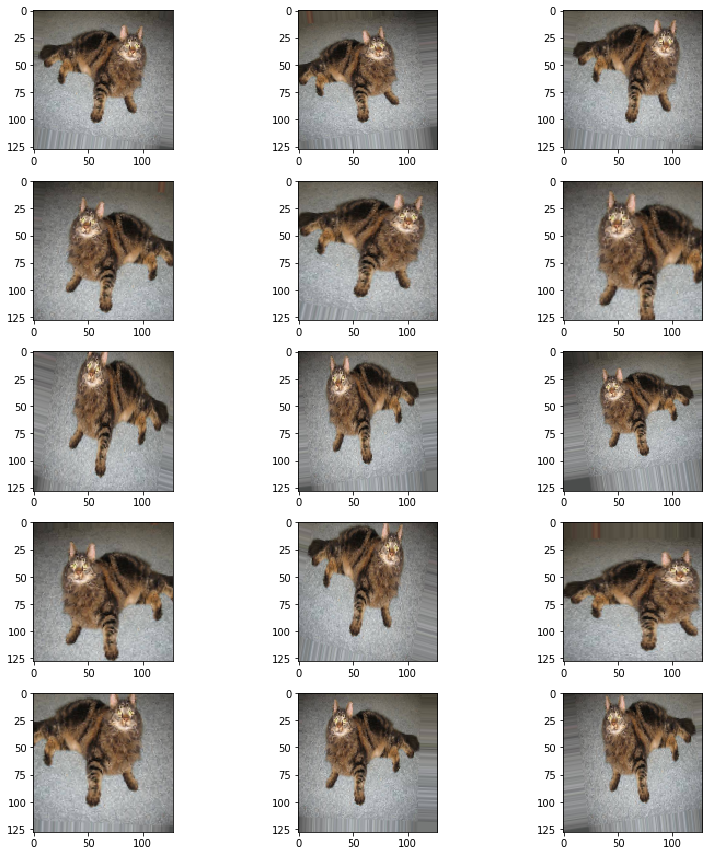

In [15]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/10
1333/1333 [==============================] - 2810s 2s/step - loss: 0.7611 - accuracy: 0.6282 - val_loss: 0.4546 - val_accuracy: 0.7039
Epoch 2/10
1333/1333 [==============================] - 1068s 801ms/step - loss: 0.5744 - accuracy: 0.7088 - val_loss: 0.6105 - val_accuracy: 0.6598
Epoch 3/10
1333/1333 [==============================] - 3615s 3s/step - loss: 0.5151 - accuracy: 0.7527 - val_loss: 0.3957 - val_accuracy: 0.7745
Epoch 4/10
1333/1333 [==============================] - 1141s 856ms/step - loss: 0.4799 - accuracy: 0.7786 - val_loss: 0.2664 - val_accuracy: 0.7753
Epoch 5/10
1333/1333 [==============================] - 1081s 811ms/step - loss: 0.4424 - accuracy: 0.7987 - val_loss: 0.5974 - val_accuracy: 0.7809
Epoch 6/10
1333/1333 [==============================] - 1123s 842ms/step - loss: 0.4204 - accuracy: 0.8084 - val_loss: 0.3180 - val_accuracy: 0.8554
Epoch 7/10
1333/1333 [==============================] - 1141s 856ms/step - loss: 0.4101 - accuracy: 0.8126 - val

In [19]:
history

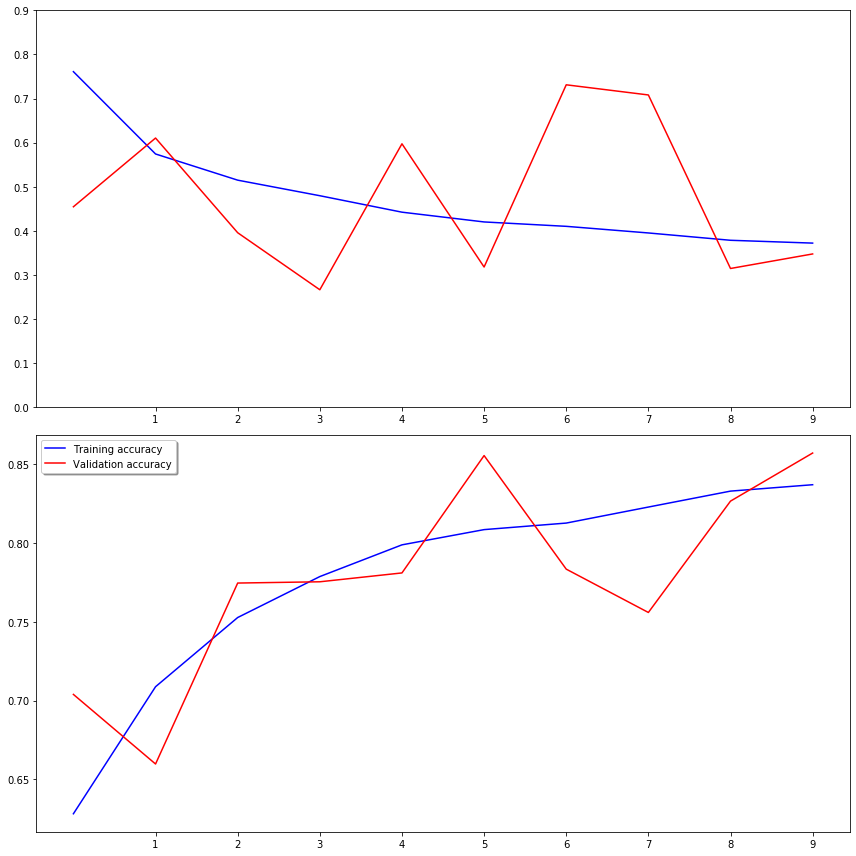

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [21]:
test_filenames = os.listdir("test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [23]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [24]:
test_df['category'] = np.argmax(predict, axis=-1)

In [25]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [26]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

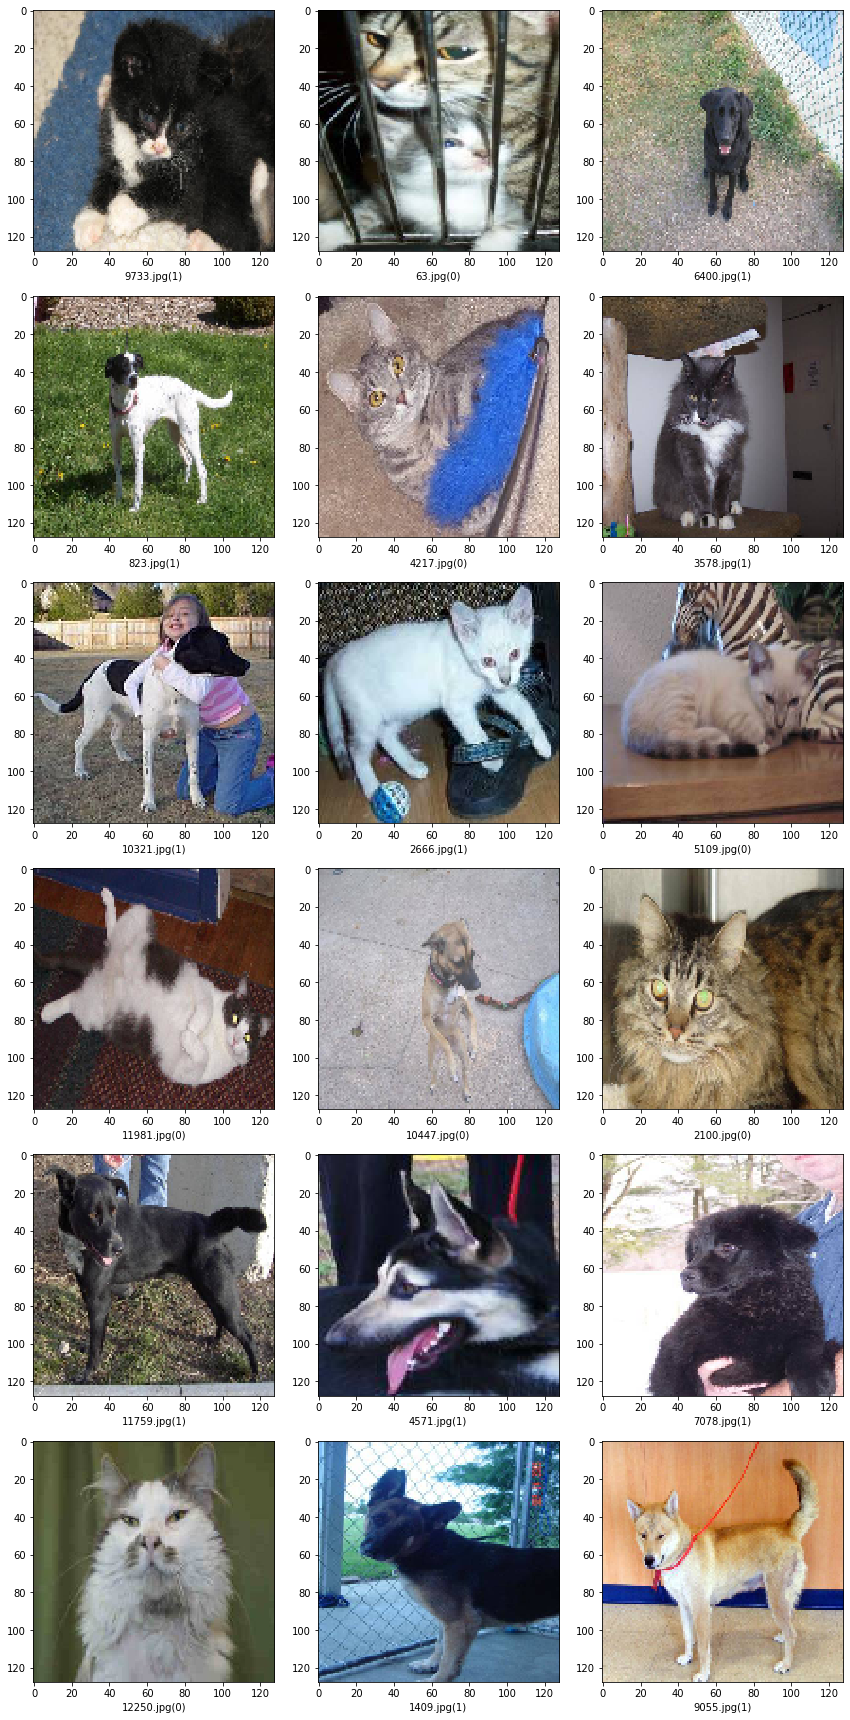

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()